In [1]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z) 
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0 
    return dZ

def sigmoid_backward(dA, cache):  
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m)) 
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0   
    return p

def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) 
    num_images = 8
    for i in range(num_images):
        index = mislabeled_indices[1][i]    
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,256,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))



In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import time
import os
%matplotlib inline

In [3]:
# create and initialize the parameters of the 2-layer neural network
""" 
    n_x: size of the input layer
    n_h: size of the hidden layer
    n_y: size of the output layer
    
    W: weight matrix of shape (n_h, n_x)
    b1: bias vector of shape (n_h, 1)
    W2: weight matrix of shape (n_y, n_h)
    b2: bias vector of shape (n_y, 1) 
                    
    The model's structure is: LINEAR -> RELU -> LINEAR -> SIGMOID  
                    
    Initializing the biases;  It is possible and common to initialize the biases to be zero, since the asymmetry breaking is provided 
    by the small random numbers in the weights.
    
    Initializing the Weights ; This serves the process of symmetry-breaking and gives much better accuracy. In this method, the weights 
    are initialized very close to zero, but randomly. This helps in breaking symmetry and every neuron is no longer performing the same computation
    
"""

def initialize_parameters(n_x, n_h, n_y): 
    W1= np.random.randn(n_h, n_x) * 0.01               
    b1= np.zeros(shape= (n_h, 1))
    W2= np.random.randn(n_y, n_h) * 0.01 
    b2= np.zeros(shape= (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [4]:
"""
Implementing the linear part of a layer's forward propagation.

    A: activations from previous layer (or input data): (size of previous layer, number of examples)
    W: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b: bias vector, numpy array of shape (size of the current layer, 1)

    
    Z: the input of the activation function, also called pre-activation parameter 
    cache: a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently

"""

def linear_forward(A, W, b):
    Z = np.dot(W, A)+b
    cache = (A, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):  
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)        
    cache = (linear_cache, activation_cache)

    return A, cache

""" 
    A_prev : activations from previous layer (or input data): (size of previous layer, number of examples)
    W: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b: bias vector, numpy array of shape (size of the current layer, 1)
    activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    A: the output of the activation function, also called the post-activation value 
    cache: a python tuple containing "linear_cache" and "activation_cache"; stored for computing the backward pass efficiently
    
"""

' \n    A_prev : activations from previous layer (or input data): (size of previous layer, number of examples)\n    W: weights matrix: numpy array of shape (size of current layer, size of previous layer)\n    b: bias vector, numpy array of shape (size of the current layer, 1)\n    activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"\n\n    A: the output of the activation function, also called the post-activation value \n    cache: a python tuple containing "linear_cache" and "activation_cache"; stored for computing the backward pass efficiently\n    \n'

In [5]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  

    for l in range(1, L):
        A_prev = A 

        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)       

    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')    
    caches.append(cache)
          
    return AL, caches

In [6]:

"""
    AL:probability vector corresponding to your label predictions, shape (1, number of examples)
    Y: true "label" vector (for example: containing 0 if printout, 1 if handwriting), shape (1, number of examples)

    Returns:
    cost:cross-entropy cost
"""

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = np.squeeze(cost)  
    cost = np.squeeze(cost)      
    return cost

In [7]:
# Backpropagation is used to calculate the gradient of the loss function with respect to the parameters. 
"""
    dZ: Gradient of the cost with respect to the linear output
    cache: tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    dA_prev: Gradient of the cost with respect to the activation , same shape as A_prev
    dW: Gradient of the cost with respect to W , same shape as W
    db: Gradient of the cost with respect to b , same shape as b
"""

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db


"""
    dA: post-activation gradient for current layer l 
    cache: tuple of values  we store for computing backward propagation efficiently
    activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    dA_prev: Gradient of the cost with respect to the activation , same shape as A_prev
    dW: Gradient of the cost with respect to W , same shape as W
    db: Gradient of the cost with respect to b , same shape as b
"""

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache) 

        
    elif activation == "sigmoid":

        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [8]:
"""
Update parameters using gradient descent

    params:   dictionary containing your parameters 
    grads:  dictionary containing your gradients, output of L_model_backward
    
    parameters: dictionary containing your updated parameters 
"""

def update_parameters(params, grads, learning_rate):
    

    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

### Resize of my image data
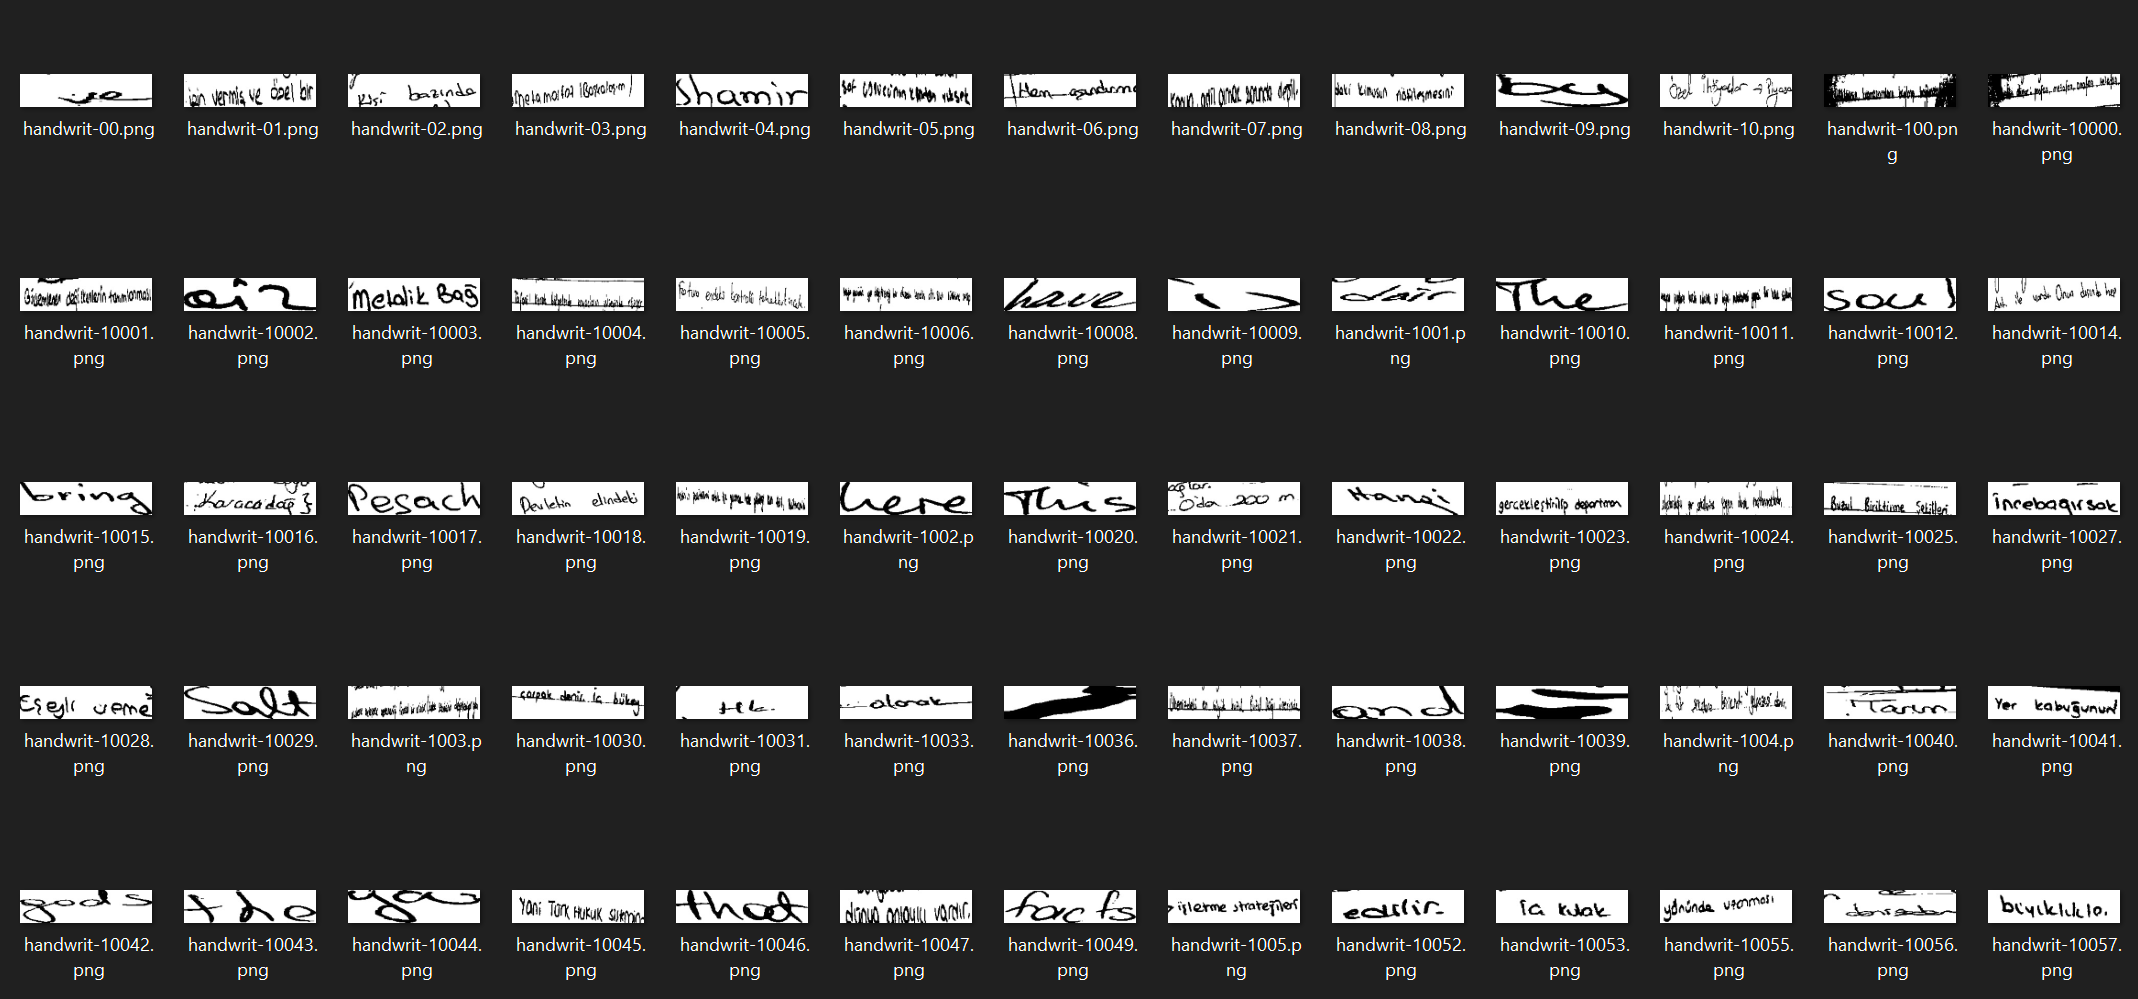

In [9]:
# To upload image of  test and train 

import cv2
import glob

path0 = glob.glob(r"C:\Users\mirza\Desktop\hand\x_train\*.png")
path1 = glob.glob(r"C:\Users\mirza\Desktop\hand\x_train\*.jpg")

x_train = []

for file in path0:
    img_train0 = cv2.imread(file)
    x_train.append([img_train0])
    
for file in path1:
    img_train1 = cv2.imread(file)
    x_train.append([img_train1])

path2 = glob.glob(r"C:\Users\mirza\Desktop\hand\x_test\*.png")
path3 = glob.glob(r"C:\Users\mirza\Desktop\hand\x_test\*.jpg")

x_test = []

for file in path2:
    img_test2 = cv2.imread(file)
    x_test.append([img_test2])
for file in path3:
    img_test3 = cv2.imread(file)
    x_test.append([img_test3])

x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)

In [10]:
print(x_train.shape)
print(x_test.shape)

(12000, 64, 256, 3)
(5000, 64, 256, 3)


In [11]:
# To label my data
import pandas as pd 

y_test= []

folder = r"C:\Users\mirza\Desktop\hand\x_test"

for img in os.listdir(folder):
    if 'handwrit' in img:            
        y_test.append((img, 1))
    elif "printout" in img:
        y_test.append((img, 0))
        

y_train= []
folder = r"C:\Users\mirza\Desktop\hand\x_train"

for img in os.listdir(folder):
    if 'handwrit' in img:            
        y_train.append((img, 1))
    elif "printout" in img:
        y_train.append((img, 0))

y_test = pd.DataFrame(y_test, columns=['name', 'label'])
y_test.to_csv('y_test.csv', index=False)

y_train = pd.DataFrame(y_train, columns=['name', 'label'])
y_train.to_csv('y_train.csv', index=False)

In [12]:
print(y_test)
print(y_train)

                       name  label
0     handwriting-12996.png      1
1     handwriting-13002.png      1
2     handwriting-13006.png      1
3     handwriting-13008.png      1
4     handwriting-13010.png      1
...                     ...    ...
4995      printout-8495.png      0
4996      printout-8496.png      0
4997      printout-8497.png      0
4998      printout-8498.png      0
4999      printout-8499.png      0

[5000 rows x 2 columns]
                     name  label
0      handwriting-00.png      1
1      handwriting-01.png      1
2      handwriting-02.png      1
3      handwriting-03.png      1
4      handwriting-05.png      1
...                   ...    ...
11995    printout-995.png      0
11996    printout-996.png      0
11997    printout-997.png      0
11998    printout-998.png      0
11999    printout-999.png      0

[12000 rows x 2 columns]


In [13]:
# shuffle data for quality learning

from sklearn.utils import shuffle
    
x_test, y_test = shuffle(x_test, y_test, random_state=0)
y_test.reset_index(drop=True)
x_train, y_train = shuffle(x_train, y_train, random_state=0)
y_train.reset_index(drop=True)

,name,label
0,handwriting-8008.png,1
1,printout-999.png,0
2,printout-5531.png,0
3,printout-2370.png,0
4,printout-969.png,0
...,...,...
11995,handwriting-7828.png,1
11996,handwriting-4664.png,1
11997,printout-4454.png,0
11998,printout-5313.png,0


In [14]:
#To define clases of my data
classes = np.array([b'printout', b'handwrit'])
classes

array([b'printout', b'handwrit'], dtype='|S8')

In [15]:
#To convert to array my labels

y_test=y_test.drop(columns=["name"])
y_test=np.array(y_test).T

y_train=y_train.drop(columns=["name"])
y_train=np.array(y_train).T

print(y_train.shape)
print(y_test.shape)

(1, 12000)
(1, 5000)


y = 1. It's a handwrit picture.


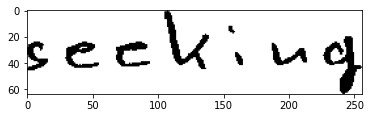

In [16]:
#Control the image and it label
index =98
plt.imshow(x_train[index])
print ("y = " + str(y_train[0,index]) + ". It's a " + classes[y_train[0,index]].decode("utf-8") +  " picture.")

In [17]:

m_train = x_train.shape[0]
num_px = x_train.shape[1]
num_wx = x_train.shape[2]
m_test = x_test.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_wx) + ", 3)")
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: 12000
Number of testing examples: 5000
Each image is of size: (64, 256, 3)
x_train shape: (12000, 64, 256, 3)
y_train shape: (1, 12000)
x_test shape: (5000, 64, 256, 3)
y_test shape: (1, 5000)


In [18]:
num_wx = x_train.shape[2]
num_wx

256

In [19]:
# Reshape the training and test examples 
train_x_flatten = x_train.reshape(x_train.shape[0], -1).T   
test_x_flatten = x_test.reshape(x_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (49152, 12000)
test_x's shape: (49152, 5000)


In [20]:
n_x = 49152    # num_wx * num_px * 3 (size of the input layer)
n_h = 7  # n_h: size of the hidden layer
n_y = 1  # n_y: size of the output layer
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [21]:

"""
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    X: input data, of shape (n_x, number of examples)
    Y: true "label" vector (containing 1 if handwriting, 0 if printout), of shape (1, number of examples)
    layers_dims: dimensions of the layers (n_x, n_h, n_y)
    num_iterations: number of iterations of the optimization loop
    learning_rate: learning rate of the gradient descent update rule
    print_cost:  If set to True, this will print the cost every 100 iterations 
    
    parameter
"""

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    grads = {}
    costs = []                   
    m = X.shape[1]                          
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    

    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")        
        cost = compute_cost(A2, Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")        
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        

        parameters = update_parameters(parameters, grads, learning_rate)       

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.693329101180635
Cost after iteration 100: 0.5320636049087272
Cost after iteration 200: 0.1363239554973507
Cost after iteration 300: 0.11335538686840402
Cost after iteration 400: 0.10070352010919673
Cost after iteration 500: 0.08998460668724753
Cost after iteration 600: 0.08045243770032683
Cost after iteration 700: 0.07275012711136337
Cost after iteration 800: 0.06696197803699556
Cost after iteration 900: 0.06243445792875379
Cost after iteration 1000: 0.05865557761101735
Cost after iteration 1100: 0.05540143885195103
Cost after iteration 1200: 0.05245316845891865
Cost after iteration 1300: 0.04983889234794937
Cost after iteration 1400: 0.047521794640856624
Cost after iteration 1500: 0.045440916877601066
Cost after iteration 1600: 0.043588095178974356
Cost after iteration 1700: 0.0419085926542418
Cost after iteration 1800: 0.040392259483589675
Cost after iteration 1900: 0.03898653445378561
Cost after iteration 1999: 0.03771964871539895


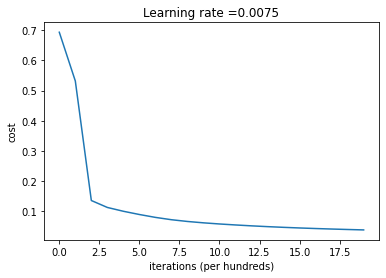

In [22]:
parameters, costs = two_layer_model(train_x, y_train, layers_dims = (n_x, n_h, n_y), num_iterations = 2000, print_cost=True)
plot_costs(costs, learning_rate)

In [23]:
pred_test =  predict(test_x, y_test, parameters)

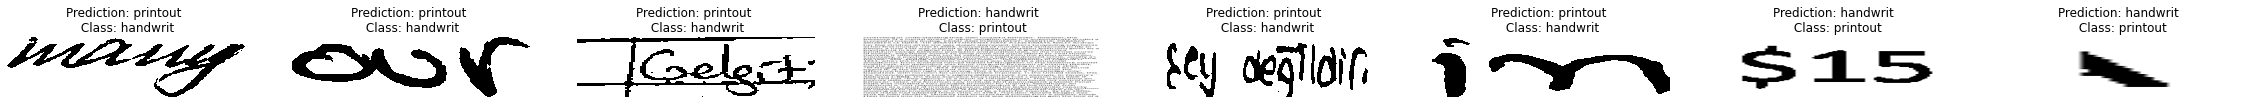

In [24]:
print_mislabeled_images(classes, test_x, y_test, pred_test)

y = 1.0, your L-layer model predicts a "handwrit" picture.


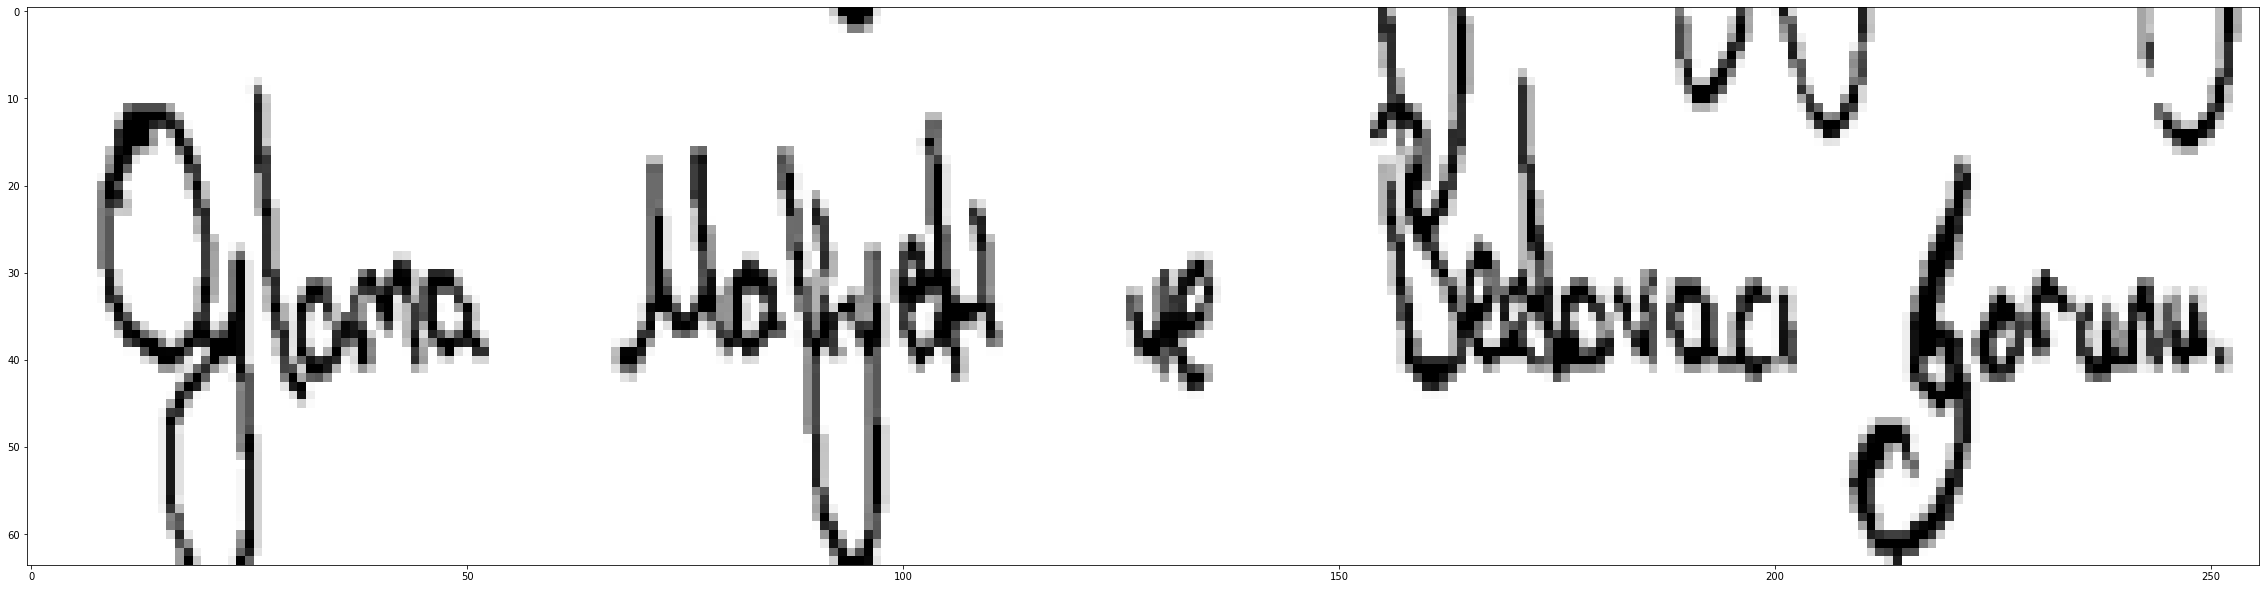

In [25]:
my_image = "test3.png"
my_label_y = [1]
fname =  my_image
image = np.array(Image.open(fname).resize((num_wx, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_wx * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)




print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 0.0, your L-layer model predicts a "printout" picture.


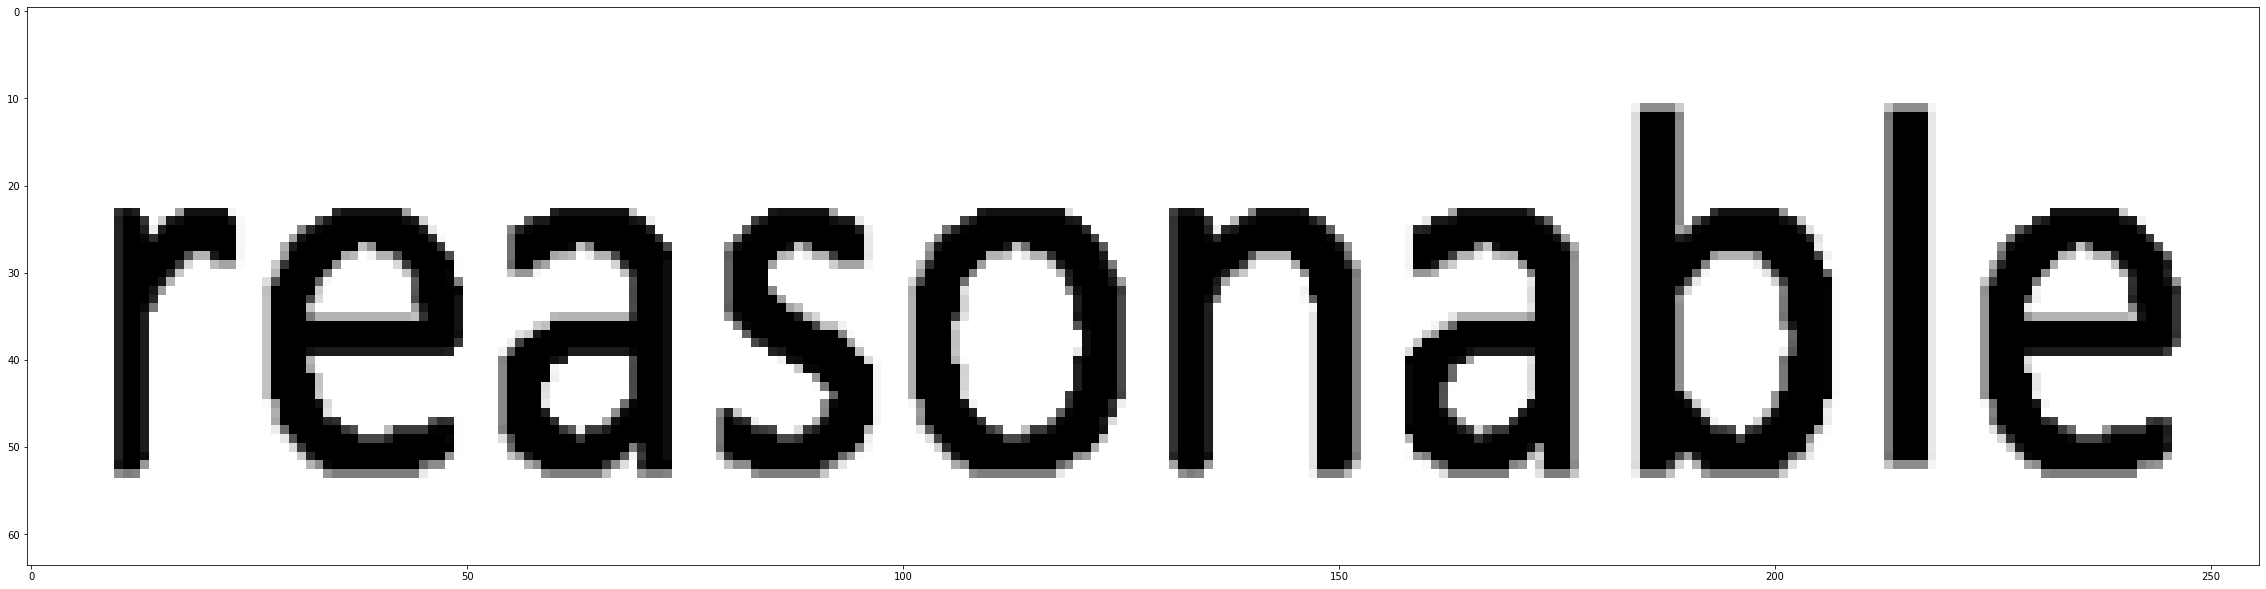

In [26]:

my_image = "printout-6159.png"
my_label_y = [0]
fname =  my_image
image = np.array(Image.open(fname).resize((num_wx, num_px)))
plt.imshow(image)
image = np.resize( image, (256,64,3))
image = image / 255.
image = image.reshape((1, num_wx * num_px * 3)).T

my_predicted_image = predict(image,my_label_y, parameters)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Accuracy: 1.0
y = 0.0, your L-layer model predicts a "printout" picture.


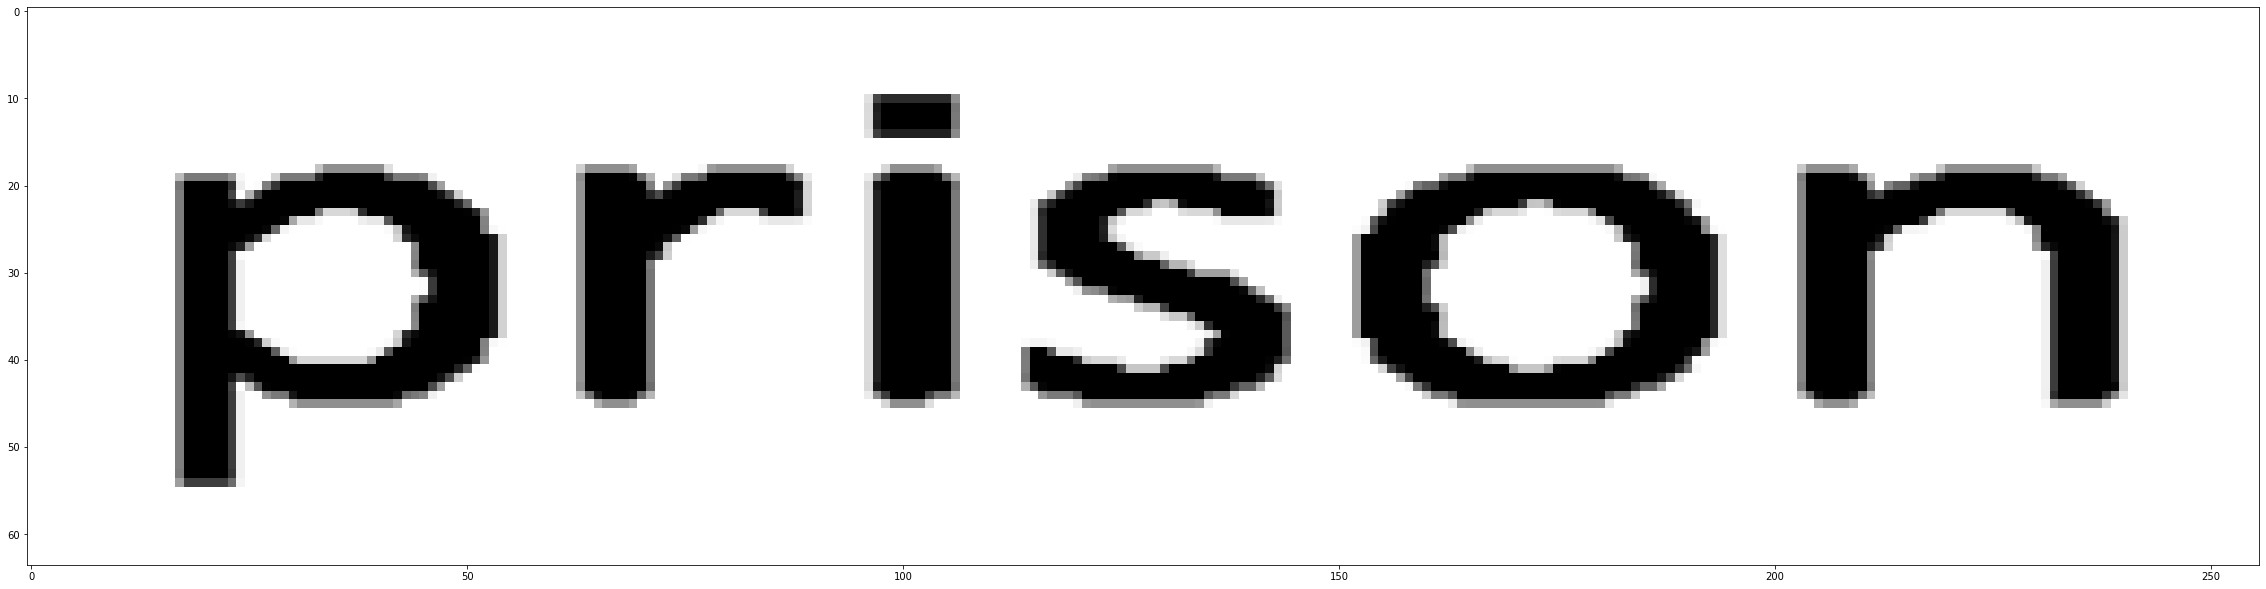

In [35]:

my_image = "printout-6151.png" # 
my_label_y = [0]
fname =  my_image
image = np.resize( image, (256,64,3))
image = image / 255.
image = image.reshape((1, num_wx * num_px * 3)).T

my_predicted_image = predict(image,my_label_y, parameters)

image = np.array(Image.open(fname).resize((num_wx, num_px)))
plt.imshow(image)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

In [28]:

def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [29]:
from sklearn import metrics
y_pred2= pd.Series(np.squeeze(pred_test))
y_test2 = pd.Series(np.squeeze(y_test))
metrics.confusion_matrix(y_test2, y_pred2)

array([[2480,   20],
       [  31, 2469]], dtype=int64)

In [30]:
pred_test =  predict(test_x, y_test, parameters)
predictions_train = predict(train_x, y_train, parameters)

Accuracy: 0.9898000000000002
Accuracy: 0.9941666666666668


In [31]:
parameters

{'W1': array([[-0.0078352 ,  0.00317017,  0.00309266, ...,  0.00409841,
         -0.01229372,  0.02014598],
        [ 0.0083891 ,  0.00261473, -0.00875544, ...,  0.00370174,
         -0.00371985, -0.01869008],
        [ 0.01844302, -0.0323881 , -0.00727883, ...,  0.00214882,
          0.01368597,  0.03210753],
        ...,
        [-0.0117964 ,  0.00779917, -0.00681961, ...,  0.00618774,
         -0.00727698, -0.00043241],
        [-0.00311653,  0.00532707,  0.0006086 , ...,  0.00908907,
         -0.00654805,  0.00746929],
        [ 0.00748946, -0.01326022, -0.00248463, ..., -0.00031078,
          0.00144204,  0.00600143]]),
 'b1': array([[-3.32375648e-05],
        [ 2.68806916e-03],
        [ 6.21104883e-03],
        [-8.22466566e-03],
        [ 4.19485514e-03],
        [-5.58682779e-05],
        [-2.49322685e-03]]),
 'W2': array([[ 0.0011537 ,  0.22704363,  0.50908707, -0.44029826,  0.41137353,
         -0.00215797, -0.15190901]]),
 'b2': array([[0.02421776]])}

In [32]:
len(parameters)

4

In [36]:
np.save('test.npy', parameters) #save model to use another time


In [37]:
d = np.load('test.npy',  allow_pickle=True)
re_dict = d.tolist()       # load parameter
re_dict

{'W1': array([[-0.0078352 ,  0.00317017,  0.00309266, ...,  0.00409841,
         -0.01229372,  0.02014598],
        [ 0.0083891 ,  0.00261473, -0.00875544, ...,  0.00370174,
         -0.00371985, -0.01869008],
        [ 0.01844302, -0.0323881 , -0.00727883, ...,  0.00214882,
          0.01368597,  0.03210753],
        ...,
        [-0.0117964 ,  0.00779917, -0.00681961, ...,  0.00618774,
         -0.00727698, -0.00043241],
        [-0.00311653,  0.00532707,  0.0006086 , ...,  0.00908907,
         -0.00654805,  0.00746929],
        [ 0.00748946, -0.01326022, -0.00248463, ..., -0.00031078,
          0.00144204,  0.00600143]]),
 'b1': array([[-3.32375648e-05],
        [ 2.68806916e-03],
        [ 6.21104883e-03],
        [-8.22466566e-03],
        [ 4.19485514e-03],
        [-5.58682779e-05],
        [-2.49322685e-03]]),
 'W2': array([[ 0.0011537 ,  0.22704363,  0.50908707, -0.44029826,  0.41137353,
         -0.00215797, -0.15190901]]),
 'b2': array([[0.02421776]])}

In [38]:
re_dict = d.tolist() # convert to şist

In [39]:
re_dict

{'W1': array([[-0.0078352 ,  0.00317017,  0.00309266, ...,  0.00409841,
         -0.01229372,  0.02014598],
        [ 0.0083891 ,  0.00261473, -0.00875544, ...,  0.00370174,
         -0.00371985, -0.01869008],
        [ 0.01844302, -0.0323881 , -0.00727883, ...,  0.00214882,
          0.01368597,  0.03210753],
        ...,
        [-0.0117964 ,  0.00779917, -0.00681961, ...,  0.00618774,
         -0.00727698, -0.00043241],
        [-0.00311653,  0.00532707,  0.0006086 , ...,  0.00908907,
         -0.00654805,  0.00746929],
        [ 0.00748946, -0.01326022, -0.00248463, ..., -0.00031078,
          0.00144204,  0.00600143]]),
 'b1': array([[-3.32375648e-05],
        [ 2.68806916e-03],
        [ 6.21104883e-03],
        [-8.22466566e-03],
        [ 4.19485514e-03],
        [-5.58682779e-05],
        [-2.49322685e-03]]),
 'W2': array([[ 0.0011537 ,  0.22704363,  0.50908707, -0.44029826,  0.41137353,
         -0.00215797, -0.15190901]]),
 'b2': array([[0.02421776]])}